# Description of the network and installed capacities before the optimization

In [42]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs
sns.set(style='darkgrid')

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 70)

import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import sets_path_to_root
sets_path_to_root("pypsa-africa")

This is the repository path:  /data/davidef/Git/pypsa-africa
Had to go 0 folder(s) up.


## load network before optimization

In [43]:
input_solve_network = os.getcwd() + '/networks/elec_s_10_ec_lv0.3_Co2L-3H.nc'

n_input = pypsa.Network(input_solve_network)

INFO:pypsa.io:Imported network elec_s_10_ec_lv0.3_Co2L-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


## Overview of the inputs and installed capacities

### Number of components by network type

In [44]:
for c in n_input.iterate_components(list(n_input.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 20 entries
Component 'Carrier' has 11 entries
Component 'GlobalConstraint' has 2 entries
Component 'Line' has 12 entries
Component 'LineType' has 31 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 20 entries
Component 'Load' has 10 entries
Component 'Generator' has 34 entries
Component 'Store' has 10 entries


### Overview of the characteristics of the network
Below we describe the main characteristics of the network are drawn:
- bus0: the first ending of the line
- bus1: the second ending of the line
- s_nom: the nominal capacity of the line
- capital_cost: the investment cost of the line
- s_nom_extendable: (True/False) binary value stating whether the line capacity can be upgraded

In [45]:
n_input.lines[['bus0', 'bus1', 's_nom', 'capital_cost', 's_nom_extendable']]

,bus0,bus1,s_nom,capital_cost,s_nom_extendable
Line,,,,,
1,NG 0,NG 1,4233.496816,11204.130316,False
2,NG 0,NG 4,3744.292739,9121.730083,False
3,NG 0,NG 8,4233.496816,12747.340852,False
4,NG 1,NG 4,1627.544331,9318.375422,False
5,NG 2,NG 7,4802.666943,6602.059716,False
6,NG 3,NG 8,1627.544331,13422.286207,False
7,NG 3,NG 9,569.170127,20813.568474,False
8,NG 4,NG 7,4313.462867,10250.421635,False
9,NG 5,NG 8,1627.544331,21608.802185,False


### Overview of the installed generation by carrier
Below we describe the main installed capacities (p_nom_opt), average specific capital cost (capital_cost) and average marginal cost (marginal_cost) by carrier and bus
- p_nom_opt: nominal installed capacity
- capital_cost: investment cost of the technology
- marginal_cost: marginal cost of the technology
- p_nom_extendable: (True/False) binary variable stating whether the capacity of the asset can be changed

In [46]:
gen_cap = n_input.generators.groupby(['bus', 'carrier'])[
    ['p_nom_opt', 'capital_cost', 'marginal_cost', 'p_nom_extendable']
    ].agg({'p_nom_opt': 'sum', 'capital_cost': 'mean', 'marginal_cost': 'mean', 'p_nom_extendable': 'sum'})
gen_cap

p_nom_opt   capital_cost  marginal_cost  p_nom_extendable
bus  carrier                                                           
NG 0 OCGT           0.0       0.000000      58.384615                 0
     oil            0.0       0.000000     130.226463                 0
     onwind         0.0  109295.569252       0.015000                 1
     ror            0.0  270940.715283       0.000000                 0
     solar          0.0   55064.071419       0.010000                 1
NG 1 OCGT           0.0       0.000000      58.384615                 0
     oil            0.0       0.000000     130.226463                 0
     onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1
NG 2 OCGT           0.0       0.000000      58.384615                 0
     oil            0.0       0.000000     130.226463                 0
     onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1
NG 3 oil            0.0       0.000000     130.226463                 0
     onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1
NG 4 OCGT           0.0       0.000000      58.384615                 0
     oil            0.0       0.000000     130.226463                 0
     onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1
NG 5 oil            0.0       0.000000     130.226463                 0
     onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1
NG 6 onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1
NG 7 OCGT           0.0       0.000000      58.384615                 0
     oil            0.0       0.000000     130.226463                 0
     onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1
NG 8 oil            0.0       0.000000     130.226463                 0
     onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1
NG 9 onwind         0.0  109295.569252       0.015000                 1
     solar          0.0   55064.071419       0.010000                 1

### Average specific energy production by node and carrier
In this picture, we detail the specific energy production by bus and carrier; the output is a panda Series
In the first column (first index) the bus name is shown; in the second column (second index), the carrier is specified and finally the energy quantity is detailed in the last column

In [47]:
n_input.generators_t.p_max_pu.sum().rename('en_pu')

Generator
NG 0 onwind    168.828449
NG 0 solar     372.326155
NG 1 onwind     93.624967
NG 1 solar     317.022575
NG 2 onwind    143.826640
NG 2 solar     370.068720
NG 3 onwind    328.309253
NG 3 solar     481.054704
NG 4 onwind     97.818724
NG 4 solar     326.804766
NG 5 onwind    338.702585
NG 5 solar     459.308645
NG 6 onwind    195.026876
NG 6 solar     431.065777
NG 7 onwind    139.746526
NG 7 solar     365.141870
NG 8 onwind    208.382612
NG 8 solar     427.929053
NG 9 onwind    316.859285
NG 9 solar     470.557333
Name: en_pu, dtype: float64

### Plot of the demand by bus
In this cells, the total demand by bus is created and denoted as `load_serie`, then it is plotted to show the location of the demand.
In the plot, the size of the dot denotes the total demand and the size of the lines in the network denotes the total network capacity between the nodes.

In [48]:
# Creation of the load series by bus
load_serie = n_input.loads_t.p_set.sum().rename("load").rename_axis("bus")

/home/davidef/.conda/envs/toast/lib/python3.9/site-packages/pypsa/plot.py:149: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(projection=projection)


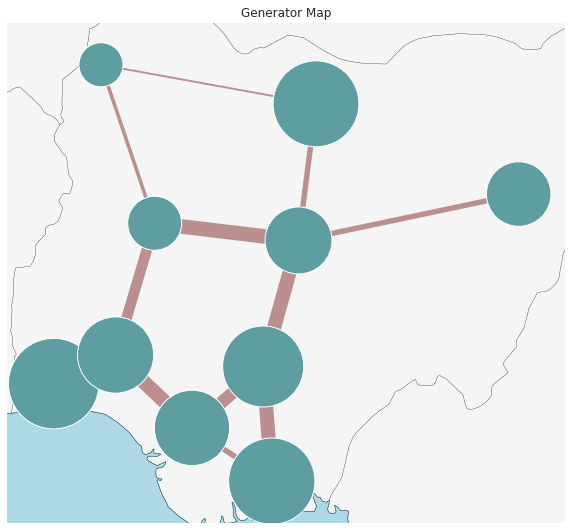

In [49]:
# plot the load serie

fig,ax = plt.subplots(
        figsize=(10,10),
        subplot_kw={"projection":ccrs.PlateCarree()} #PlateCarree(default), Mercator, Orthographic
)

n_input.plot(margin=0.1, 
        ax=None, 
        geomap=True, #'10m' leads to a beautiful high resolution map 
        projection= None, 
        bus_colors='cadetblue', 
        bus_alpha=1, 
        bus_sizes=load_serie*.0000003, #n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003, 
        bus_cmap=None, 
        line_colors='rosybrown', 
        link_colors='darkseagreen', #loading
        transformer_colors='orange', 
        line_widths=n_input.lines.s_nom/3e2, 
        link_widths=1.5, 
        transformer_widths=1.5, 
        line_cmap=None, 
        link_cmap=None, #plt.cm.virdis (colordmap for line loading)
        transformer_cmap=None, 
        flow=None, 
        branch_components=None, 
        layouter=None, 
        title='Generator Map', 
        boundaries=None, 
        geometry=False, 
        jitter=None, 
        color_geomap=True)#None or True

ax.axis('off');